# Análisis Exploratorio de los Microdatos del Censo 2017

Por **Eduardo Graells-Garrido** y Daniela Opitz. <dopitz@udd.cl>.
Actualizado: **14 de mayo de 2024**.

En este notebook muestro cómo cargar datos del Censo 2017 para generar mapas de coropletas.

Particularmente haremos tres mapas:

  * ¿Cuál es la distribución de les inmigrantes en Santiago?
  * ¿Cuál es la distribución de las personas mayores de 65 años en Santiago?
  * ¿Dónde viven más hombres o mujeres?

Los datos se han obtenido de las siguientes fuentes (y están incluidos en este repositorio):

  * [Microdatos del Censo 2017](http://www.censo2017.cl/microdatos/)
  * [Shapefile de Distritos Censales](https://github.com/justinelliotmeyers/official_chile_2017_census_boundary_shapefile)
  * [Shapefile de áreas urbanas del país](https://www.bcn.cl/siit/mapas_vectoriales/index_html)

Comencemos.

## Preámbulo


Y descargar los datos si es que estás usando Google Colab

In [1]:
try:
    import google.colab
    !curl -L -o censo2017.zip 'https://www.dropbox.com/scl/fi/gx94xhhvwm5ncilwyt0yc/censo2017.zip?rlkey=zufb4zjrbx614gep3pra5qix5&st=pl1s7cde&dl='
    !unzip -o censo2017.zip
except:
    pass

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    405      0 --:--:-- --:--:-- --:--:--   405
100   491    0   491    0     0    385      0 --:--:--  0:00:01 --:--:--     0
100  267M  100  267M    0     0  47.7M      0  0:00:05  0:00:05 --:--:-- 73.5M
Archive:  censo2017.zip
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Categorias.csv  
 extracting: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Areas.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Regiones.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Comunas.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Urbano.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Geografia.csv  
  inflat

In [2]:
try:
    import google.colab
     # Descargar y descomprimir el archivo
    !curl -L -o Fira_Sans_Extra_Condensed.zip 'https://github.com/daniopitz/visualizacion/raw/main/otros/Fira_Sans_Extra_Condensed.zip'
    !unzip -o Fira_Sans_Extra_Condensed.zip

    # Importar y añadir la fuente
    import matplotlib as mpl
    mpl.font_manager.fontManager.addfont('Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-Regular.ttf')

except:
    pass

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3727k  100 3727k    0     0  3510k      0  0:00:01  0:00:01 --:--:-- 14.6M
Archive:  Fira_Sans_Extra_Condensed.zip
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-MediumItalic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-Italic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-BlackItalic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-Light.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-LightItalic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-BoldItalic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-ThinItalic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-ExtraLight.ttf  
  inflating: Fira

Aquí cargamos las bibliotecas que necesitamos utilizar y configuramos el sistema.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font='sans-serif', context='notebook', palette='viridis')
%config InlineBackend.figure_format='retina'

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
plt.rcParams["figure.dpi"] = 96
# esto depende de las fuentes que tengas instaladas en tu sistema.
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [4]:
pd.set_option('display.max_columns', None)

## Carga de Datos



Voy a montar mi directorio de Google Drive. Ajustar a suyo.

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
try:
    import google.colab
    !curl -L -o Microdato_Censo2017-Urbano.csv 'https://www.dropbox.com/scl/fi/4l4q1dnwr3rpiohc7lcdr/Microdato_Censo2017-Urbano.csv?rlkey=6lbi9u8g0fam6lb4q5sw2hyz3&st=lv6700rd&dl=0'
except:
    pass

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    405      0 --:--:-- --:--:-- --:--:--   405
100  147k  100  147k    0     0   151k      0 --:--:-- --:--:-- --:--:--  151k


Comencemos. Lo primero que hacemos es cargar los datos. Aquí hacemos una serie de operaciones de modo de quedarnos solamente con la región metropolitana. Vamos a cargar los datos de dos formas, de la manera larga y de la manera corta.

En el código, el método pipe se utiliza para aplicar una función específica al DataFrame resultante de la operación de fusión. La función dentro de pipe, definida como una expresión lambda, se encarga de filtrar el DataFrame. La función lambda x: x[x.REGION == 13] selecciona sólo las filas en las que el valor de la columna 'REGION' es igual a 13, es decir, filtra el DataFrame para incluir sólo aquellas filas pertenecientes a la Región Metropolitana de Santiago.

Forma larga pero más sencilla de cargar los datos

In [7]:
# Cargando los datos
data1 = pd.read_csv('censo2017/Censo2017_ManzanaEntidad_CSV/Censo2017_Manzanas.csv', sep=';')
data2 = pd.read_csv('Microdato_Censo2017-Urbano.csv', sep=';')



In [8]:
data1.head()

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
0       1         11    1101   1     1       1       1         7849   
1       1         11    1101   1     1       1      10         7849   
2       1         11    1101   1     1       1      11         7849   
3       1         11    1101   1     1       1      12         7849   
4       1         11    1101   1     1       1      13         7849   

      ID_MANZENT  PERSONAS HOMBRES MUJERES EDAD_0A5 EDAD_6A14 EDAD_15A64  \
0  1101011001001        15       *       *        0         0         15   
1  1101011001010        70      38      32        *         *         54   
2  1101011001011        36      21      15        *         0         28   
3  1101011001012        65      34      31        *         7         49   
4  1101011001013        39      12      27        *         *         26   

  EDAD_65YMAS INMIGRANTES PUEBLO  VIV_PART  VIV_COL  MATACEP  MATREC  \
0           0           0      0         1        2        0       0   
1          10          12     13        17        1       14       1   
2           *          11      7        15        1       10       5   
3           *          27      4        24        0       11       9   
4           7           4     17        11        2        9       0   

   MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  P03A_4  P03A_5  P03A_6  \
0         0      0          3       0       0       0       0       0       0   
1         0     15         18       0       1      13       1       0       0   
2         0     15         16       0       0      15       0       0       0   
3         4     24         24       2       4      11       7       0       0   
4         0      9         13       0       4       5       0       0       0   

   P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  P03B_6  P03B_7  P03C_1  P03C_2  \
0       0       0       0       0       0       0       0       0       0   
1       8       0       7       0       0       0       0      15       0   
2       0       0      15       0       0       0       0      10       0   
3       5       2      13       0       0       3       1      18       1   
4       6       0       3       0       0       0       0       9       0   

   P03C_3  P03C_4  P03C_5  P05_1  P05_2  P05_3  P05_4  
0       0       0       0      0      0      0      0  
1       0       0       0     15      0      0      0  
2       0       5       0     15      0      0      0  
3       4       1       0     24      0      0      0  
4       0       0       0      9      0      0      0

In [9]:
data2.head()

REGION  PROVINCIA  COMUNA  DC  AREA  ZONA NOM_URBANO  CAT
0       1         11    1101   1     1     1    IQUIQUE    1
1       1         11    1101   1     1     2    IQUIQUE    1
2       1         11    1101   2     1     1    IQUIQUE    1
3       1         11    1101   2     1     2    IQUIQUE    1
4       1         11    1101   2     1     3    IQUIQUE    1

In [10]:
# Fusionando los dataframes
census = data1.merge(data2)

# Filtrando por la región
census = census[census.REGION == 13]

# Eliminando la columna 'ZONA' y duplicados
census = census.drop('ZONA', axis=1).drop_duplicates()

# Mostrando las primeras filas del DataFrame resultante
census.head()

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
531736      13        131   13101   1     1       1       3         1279   
531741      13        131   13101   1     1       1       4         1279   
531746      13        131   13101   1     1       1       5         1279   
531751      13        131   13101   1     1       1       6         1279   
531756      13        131   13101   1     1       1       7         1279   

            ID_MANZENT  PERSONAS HOMBRES MUJERES EDAD_0A5 EDAD_6A14  \
531736  13101011001003       421     196     225       24        18   
531741  13101011001004       185      90      95        *         *   
531746  13101011001005       776     390     386       30        27   
531751  13101011001006       416     209     207       14        10   
531756  13101011001007       376     211     165        *         *   

       EDAD_15A64 EDAD_65YMAS INMIGRANTES PUEBLO  VIV_PART  VIV_COL  MATACEP  \
531736        299          80          63     28       249        1      181   
531741        137          41          22     20       154        0      111   
531746        636          83         132     54       515        2      416   
531751        337          55          59     51       292        1      222   
531756        315          40          55     28       279        2      187   

        MATREC  MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  P03A_4  \
531736       0         0    189        250     159      29       0       0   
531741       0         0    115        154     108       5       0       0   
531746       1         0    422        517     385      35       0       0   
531751       1         0    225        293     196      28       0       0   
531756       1         0    195        281     140      49       1       0   

        P03A_5  P03A_6  P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  P03B_6  \
531736       0       0      32     136      15       0       0       0   
531741       0       0       1     108       2       0       0       0   
531746       1       0      60     333      25       1       0       0   
531751       1       0      91     114      19       0       0       0   
531756       1       0      27     135      28       0       0       0   

        P03B_7  P03C_1  P03C_2  P03C_3  P03C_4  P03C_5  P05_1  P05_2  P05_3  \
531736       0     186       0       0       0       0    188      0      0   
531741       0     113       0       0       0       0    113      0      0   
531746       0     419       1       0       0       0    422      0      0   
531751       0     224       0       0       0       0    222      0      0   
531756       0     191       0       0       0       0    195      0      0   

        P05_4 NOM_URBANO  CAT  
531736      0   SANTIAGO    1  
531741      0   SANTIAGO    1  
531746      0   SANTIAGO    1  
531751      0   SANTIAGO    1  
531756      0   SANTIAGO    1

Forma corta

In [11]:
census = (pd.read_csv('censo2017/Censo2017_ManzanaEntidad_CSV/Censo2017_Manzanas.csv', sep=';')
          .merge(pd.read_csv('Microdato_Censo2017-Urbano.csv', sep=';'))
          .pipe(lambda x: x[x.REGION == 13])
          .drop('ZONA', axis=1)
          .drop_duplicates()
         )
census.head()

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
531736      13        131   13101   1     1       1       3         1279   
531741      13        131   13101   1     1       1       4         1279   
531746      13        131   13101   1     1       1       5         1279   
531751      13        131   13101   1     1       1       6         1279   
531756      13        131   13101   1     1       1       7         1279   

            ID_MANZENT  PERSONAS HOMBRES MUJERES EDAD_0A5 EDAD_6A14  \
531736  13101011001003       421     196     225       24        18   
531741  13101011001004       185      90      95        *         *   
531746  13101011001005       776     390     386       30        27   
531751  13101011001006       416     209     207       14        10   
531756  13101011001007       376     211     165        *         *   

       EDAD_15A64 EDAD_65YMAS INMIGRANTES PUEBLO  VIV_PART  VIV_COL  MATACEP  \
531736        299          80          63     28       249        1      181   
531741        137          41          22     20       154        0      111   
531746        636          83         132     54       515        2      416   
531751        337          55          59     51       292        1      222   
531756        315          40          55     28       279        2      187   

        MATREC  MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  P03A_4  \
531736       0         0    189        250     159      29       0       0   
531741       0         0    115        154     108       5       0       0   
531746       1         0    422        517     385      35       0       0   
531751       1         0    225        293     196      28       0       0   
531756       1         0    195        281     140      49       1       0   

        P03A_5  P03A_6  P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  P03B_6  \
531736       0       0      32     136      15       0       0       0   
531741       0       0       1     108       2       0       0       0   
531746       1       0      60     333      25       1       0       0   
531751       1       0      91     114      19       0       0       0   
531756       1       0      27     135      28       0       0       0   

        P03B_7  P03C_1  P03C_2  P03C_3  P03C_4  P03C_5  P05_1  P05_2  P05_3  \
531736       0     186       0       0       0       0    188      0      0   
531741       0     113       0       0       0       0    113      0      0   
531746       0     419       1       0       0       0    422      0      0   
531751       0     224       0       0       0       0    222      0      0   
531756       0     191       0       0       0       0    195      0      0   

        P05_4 NOM_URBANO  CAT  
531736      0   SANTIAGO    1  
531741      0   SANTIAGO    1  
531746      0   SANTIAGO    1  
531751      0   SANTIAGO    1  
531756      0   SANTIAGO    1

Creamos una lista con las variables que nos interesan.

- **HOMBRES**: Número de hombres en la población censada.
- **MUJERES**: Número de mujeres en la población censada.
- **EDAD_0A5**: Número de personas en la población censada que tienen entre 0 y 5 años de edad.
- **EDAD_6A14**: Número de personas en la población censada que tienen entre 6 y 14 años de edad.
- **EDAD_15A64**: Número de personas en la población censada que tienen entre 15 y 64 años de edad.
- **EDAD_65YMAS**: Número de personas en la población censada que tienen 65 años o más.
- **INMIGRANTES**: Número de personas en la población censada que son inmigrantes.


In [12]:
count_columns = ['HOMBRES', 'MUJERES','EDAD_0A5', 'EDAD_6A14', 'EDAD_15A64', 'EDAD_65YMAS', 'INMIGRANTES']

Si vemos el manual de uso de la base de datos, hay ocasiones en los que esas columnas no tienen valor. Con esto lo arreglamos, reemplazando el valor anónimo por un 0.

In [13]:
for col in count_columns:
    census[col] = census[col].replace('*', 0).astype(int)

In [14]:
census.sample(10)

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
658179      13        131   13119   8     1       2     901        10827   
707139      13        131   13125   1     1       7       7        13162   
610905      13        131   13116   1     1       5       9         2357   
815134      13        134   13401   6     1      14      22         6546   
674870      13        131   13122   4     1       5       5         6640   
617779      13        131   13118   2     1       7       4         9081   
846742      13        136   13605   3     1       2      28        15216   
549236      13        131   13104   5     1       4      29         4007   
708780      13        131   13125   2     1      11       6         9290   
557365      13        131   13106  14     1       2      23         2887   

            ID_MANZENT  PERSONAS  HOMBRES  MUJERES  EDAD_0A5  EDAD_6A14  \
658179  13119081002901        68       35       33         6          5   
707139  13125011007007       319      166      153        45         29   
610905  13116011005009       296      133      163        17         31   
815134  13401061014022       101       47       54         0         23   
674870  13122041005005        48       23       25         6          0   
617779  13118021007004        74       33       41         0          8   
846742  13605031002028        22        9       13         0          0   
549236  13104051004029        62       34       28        10          0   
708780  13125021011006       450      226      224         0         67   
557365  13106141002023        79       43       36         6          8   

        EDAD_15A64  EDAD_65YMAS  INMIGRANTES PUEBLO  VIV_PART  VIV_COL  \
658179          50            7            0     15        24        0   
707139         238            7           35     25       104        0   
610905         194           54           21     35        90        0   
815134          63            0            0     16        27        0   
674870          35            0            0      6        15        0   
617779          57            0            0      4        27        0   
846742          12            0            0      0         8        0   
549236          42            0           31     11        16        0   
708780         326            0           61     43       120        0   
557365          51           14            7      *        19        0   

        MATACEP  MATREC  MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  \
658179       21       1         0     22         24       3      18       0   
707139      104       0         0    104        104      27      76       1   
610905       68      18         0     87         90       7      28      43   
815134       27       0         0     27         27       1      26       0   
674870        9       6         0     15         15       0       8       4   
617779       25       0         0     26         27       0      25       0   
846742        7       0         0      7          8       7       0       0   
549236       14       1         0     16         16       0       4      11   
708780      108       0         0    117        120      40      73       0   
557365       16       3         0     19         19       1      12       4   

        P03A_4  P03A_5  P03A_6  P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  \
658179       1       0       0       6       0      16       0       0   
707139       0       0       0      99       0       5       0       0   
610905       4       5       0       8       0      78       0       0   
815134       0       0       0      11       0      16       0       0   
674870       3       0       0       0       0      15       0       0   
617779       0       0       0       0       0      26       0       0   
846742       0       0       0       7       0       0       0       0   
549236       0       0       0       8       0       7       0      

Ahora sumemos la población por cada variable, agrupando por distrito censal.

Un distrito censal, según el Censo 2017 de Chile, es una subdivisión geográfica utilizada para la recopilación y el análisis de datos censales. Los distritos censales son unidades más pequeñas que las comunas y más grandes que las manzanas censales. Están diseñados para facilitar la organización y ejecución del censo y permitir una mejor gestión y análisis de los datos.

In [15]:
dc_values = census.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'DC'])[count_columns].sum().reset_index().rename(columns={'DC': 'COD_DISTRI'})

In [16]:
dc_values.sample(5)

REGION  PROVINCIA  COMUNA  COD_DISTRI  HOMBRES  MUJERES  EDAD_0A5  \
218      13        131   13121           7     6425     6613       922   
345      13        133   13303           1     2760     2789       337   
211      13        131   13120          11     9703    11562      1478   
126      13        131   13112           3    11178    11400      1658   
246      13        131   13124           8      516      501        57   

     EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  
218       1401        8997         1659          458  
345        573        3793          587           25  
211       1362       15635         2443         2069  
126       2512       14658         3437          227  
246        169         701           27            5

¡Listo! Con eso ya tenemos nuestros datos preparados para ser visualizados. Antes de hacer eso, nos encargaremos de quedarnos con los distritos dentro del área urbana de Santiago.

## Cargando la Geografía

Así leemos la cartografía de las áreas urbanas:

## Borde Urbano de la RM

<Axes: >

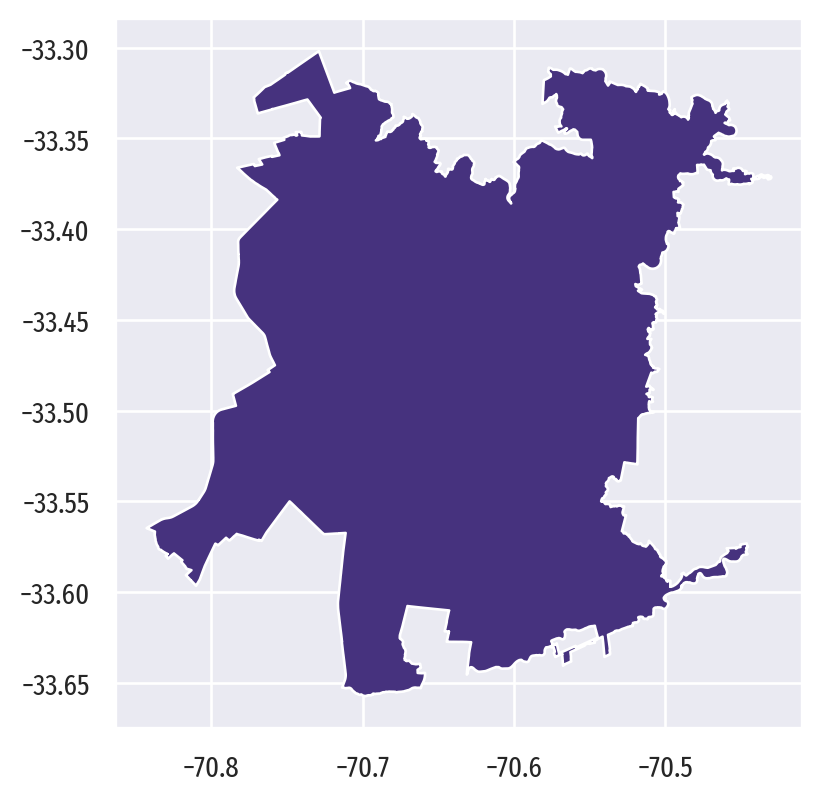

In [17]:
# Leer el archivo GeoJSON
urban_stgo = gpd.read_file('censo2017/urban_stgo_border/urban_stgo_border.shp')

# Establecer el sistema de referencia de coordenadas inicial
urban_stgo = urban_stgo.set_crs('EPSG:4326')

# Cambiar el sistema de referencia de coordenadas a EPSG:4326 (hay otros)
urban_stgo = urban_stgo.to_crs('EPSG:4326')

# Hacer el gráfico de las áreas urbanas de Santiago
urban_stgo.plot()

In [18]:
urban_stgo

FID                                           geometry
0    0  POLYGON ((-70.76164 -33.56445, -70.76198 -33.5...

Esa área urbana define el borde del área que nos interesa estudiar, pero necesitamos cargar los bordes de cada distrito censal. Lo hacemos como sigue:

## Distritos

In [19]:
# Leer el archivo GeoJSON
distritos = gpd.read_file('./censo2017/R13/')
distritos

REGION PROVINCIA COMUNA  COD_DISTRI                        DESC_REGIO  \
0       13       131  13114         4.0  REGIÓN METROPOLITANA DE SANTIAGO   
1       13       131  13114        15.0  REGIÓN METROPOLITANA DE SANTIAGO   
2       13       131  13114        16.0  REGIÓN METROPOLITANA DE SANTIAGO   
3       13       131  13114         2.0  REGIÓN METROPOLITANA DE SANTIAGO   
4       13       131  13114         3.0  REGIÓN METROPOLITANA DE SANTIAGO   
..     ...       ...    ...         ...                               ...   
446     13       135  13501         1.0  REGIÓN METROPOLITANA DE SANTIAGO   
447     13       135  13501         7.0  REGIÓN METROPOLITANA DE SANTIAGO   
448     13       135  13501        13.0  REGIÓN METROPOLITANA DE SANTIAGO   
449     13       135  13501         8.0  REGIÓN METROPOLITANA DE SANTIAGO   
450     13       131  13118         5.0  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI  DESC_COMUN                      DESC_DISTR  \
0     SANTIAGO  LAS CONDES                      LAS CONDES   
1     SANTIAGO  LAS CONDES         SAN CARLOS DE APOQUINDO   
2     SANTIAGO  LAS CONDES                     CERRO CALÁN   
3     SANTIAGO  LAS CONDES               ESTADIO PALESTINO   
4     SANTIAGO  LAS CONDES                   HOSPITAL FACH   
..         ...         ...                             ...   
446  MELIPILLA   MELIPILLA              MELIPILLA PONIENTE   
447  MELIPILLA   MELIPILLA                        CULIPRÁN   
448  MELIPILLA   MELIPILLA                PUANGUE PONIENTE   
449  MELIPILLA   MELIPILLA                         HUECHÚN   
450   SANTIAGO       MACUL  VILLA SANTA CAROLINA VILLA SAN   

                                              geometry  
0    POLYGON ((-70.47951 -33.36433, -70.47940 -33.3...  
1    POLYGON ((-70.50074 -33.37846, -70.50045 -33.3...  
2    POLYGON ((-70.50789 -33.38245, -70.50774 -33.3...  
3    POLYGON ((-70.53606 -33.38529, -70.53652 -33.3...  
4    POLYGON ((-70.54504 -33.39658, -70.54575 -33.3...  
..                                                 ...  
446  POLYGON ((-71.22747 -33.67002, -71.22402 -33.6...  
447  POLYGON ((-71.19488 -33.78527, -71.19403 -33.7...  
448  POLYGON ((-71.31653 -33.58829, -71.31629 -33.5...  
449  POLYGON ((-71.32236 -33.66578, -71.32134 -33.6...  
450  POLYGON ((-70.59876 -33.47380, -70.59881 -33.4...  

[451 rows x 9 columns]

In [20]:
# Convertir las columnas a enteros
distritos['REGION'] = distritos['REGION'].astype(int)
distritos['PROVINCIA'] = distritos['PROVINCIA'].astype(int)
distritos['COMUNA'] = distritos['COMUNA'].astype(int)
distritos['COD_DISTRI'] = distritos['COD_DISTRI'].astype(int)

# Obtener la longitud del GeoDataFrame
distritos_len= len(distritos)
print(distritos_len)

451


En la RM hay 451 distritos censales. Por cierto, los valores de región, provincia, comuna y distrito no vienen como números enteros, por eso debimos realizar esas operaciones `astype`.

Grafiquemos los distritos:

In [21]:
distritos.head()

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0      13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1      13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2      13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3      13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4      13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   

  DESC_PROVI  DESC_COMUN               DESC_DISTR  \
0   SANTIAGO  LAS CONDES               LAS CONDES   
1   SANTIAGO  LAS CONDES  SAN CARLOS DE APOQUINDO   
2   SANTIAGO  LAS CONDES              CERRO CALÁN   
3   SANTIAGO  LAS CONDES        ESTADIO PALESTINO   
4   SANTIAGO  LAS CONDES            HOSPITAL FACH   

                                            geometry  
0  POLYGON ((-70.47951 -33.36433, -70.47940 -33.3...  
1  POLYGON ((-70.50074 -33.37846, -70.50045 -33.3...  
2  POLYGON ((-70.50789 -33.38245, -70.50774 -33.3...  
3  POLYGON ((-70.53606 -33.38529, -70.53652 -33.3...  
4  POLYGON ((-70.54504 -33.39658, -70.54575 -33.3...

Como está toda la región, necesitamos quedarnos con los distritos que se intersectan con el área urbana. Lo hacemos así:

In [22]:
# Verificar el CRS actual
print("CRS de distritos:", distritos.crs)
print("CRS de urban_stgo:", urban_stgo.crs)



CRS de distritos: EPSG:4674
CRS de urban_stgo: EPSG:4326


CRS de distritos transformado: EPSG:4326
CRS de urban_stgo: EPSG:4326


<Axes: >

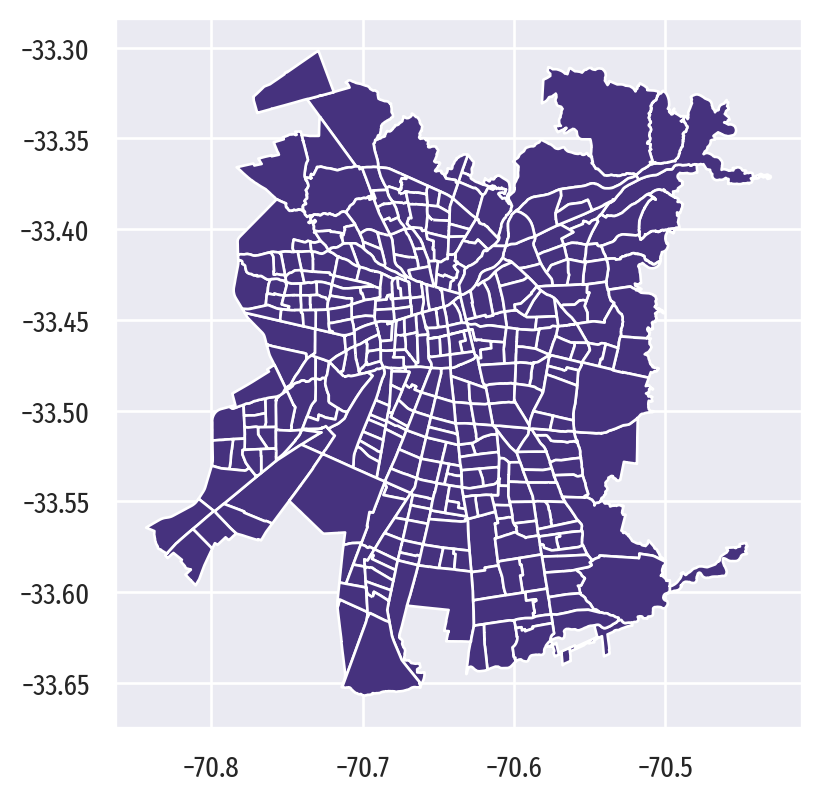

In [23]:
# Transformar el CRS de distritos a EPSG:4326
distritos = distritos.to_crs('EPSG:4326')

# Verificar que ambos GeoDataFrames tienen el mismo CRS
print("CRS de distritos transformado:", distritos.crs)
print("CRS de urban_stgo:", urban_stgo.crs)

# Realizar la intersección
urban_districts = gpd.overlay(distritos, urban_stgo, how='intersection')

# Hacer el gráfico de la intersección
urban_districts.plot()


In [24]:
urban_districts.head()

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0      13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1      13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2      13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3      13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4      13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   

  DESC_PROVI  DESC_COMUN               DESC_DISTR  FID  \
0   SANTIAGO  LAS CONDES               LAS CONDES    0   
1   SANTIAGO  LAS CONDES  SAN CARLOS DE APOQUINDO    0   
2   SANTIAGO  LAS CONDES              CERRO CALÁN    0   
3   SANTIAGO  LAS CONDES        ESTADIO PALESTINO    0   
4   SANTIAGO  LAS CONDES            HOSPITAL FACH    0   

                                            geometry  
0  POLYGON ((-70.47940 -33.36434, -70.47931 -33.3...  
1  POLYGON ((-70.50045 -33.37855, -70.50037 -33.3...  
2  POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...  
3  POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...  
4  POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...

In [25]:
urban_districts.shape

(347, 10)

Podemos guardar este mapa para utilizarlo más adelante.

In [26]:
!mkdir -p output/

In [27]:
# Utilizamos el método 'to_file' del GeoDataFrame 'urban_districts' para guardar los datos geográficos.
# Este método permite exportar el GeoDataFrame a un archivo en un formato específico, en este caso, un shapefile.
urban_districts.to_file('output/stgo_urban_districts.shp', driver='ESRI Shapefile')

# El primer argumento 'output/stgo_urban_districts.shp' indica la ruta de archivo y el nombre bajo el cual se guardará el archivo.


Ahora mezclémoslos con los datos.

In [28]:
urban_data = urban_districts.merge(dc_values, how='inner')

In [29]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
342      13        136   13604           1  REGIÓN METROPOLITANA DE SANTIAGO   
343      13        136   13604           3  REGIÓN METROPOLITANA DE SANTIAGO   
344      13        136   13604           4  REGIÓN METROPOLITANA DE SANTIAGO   
345      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
346      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI     DESC_COMUN                      DESC_DISTR  FID  \
0     SANTIAGO     LAS CONDES                      LAS CONDES    0   
1     SANTIAGO     LAS CONDES         SAN CARLOS DE APOQUINDO    0   
2     SANTIAGO     LAS CONDES                     CERRO CALÁN    0   
3     SANTIAGO     LAS CONDES               ESTADIO PALESTINO    0   
4     SANTIAGO     LAS CONDES                   HOSPITAL FACH    0   
..         ...            ...                             ...  ...   
342  TALAGANTE  PADRE HURTADO              CASA DE EJERCICIOS    0   
343  TALAGANTE  PADRE HURTADO                   PADRE HURTADO    0   
344  TALAGANTE  PADRE HURTADO                 VILLA LOS SILOS    0   
345  CHACABUCO          LAMPA                       LA VILANA    0   
346   SANTIAGO          MACUL  VILLA SANTA CAROLINA VILLA SAN    0   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.47940 -33.36434, -70.47931 -33.3...     7140     8978   
1    POLYGON ((-70.50045 -33.37855, -70.50037 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
342  POLYGON ((-70.80540 -33.55063, -70.80288 -33.5...     3556     3697   
343  POLYGON ((-70.79794 -33.55565, -70.79794 -33.5...     9742     9924   
344  POLYGON ((-70.82936 -33.57881, -70.82933 -33.5...    14139    14479   
345  POLYGON ((-70.72696 -33.32623, -70.72699 -33.3...    32895    32577   
346  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  
0        1021       1562       10831         2466         1487  
1         936       2489       12392          884         1632  
2         616       1412        9940         2337         1180  
3         949        999        9862         2195         1632  
4        1033       1236       13872         2966         2716  
..        ...        ...         ...          ...          ...  
342       818        718        4888          309          158  
343      1540       2193       13318         2205          508  
344      2272       3598       19935         2003          593  
345      7632       8898       44553         1758         2757  
346       735        897        7854         1716          613  

[347 rows x 17 columns]

Ahora nuestros datos censales a nivesl de distrito están unidos a la geografía de cada distrito (poligono en la columna geometry)

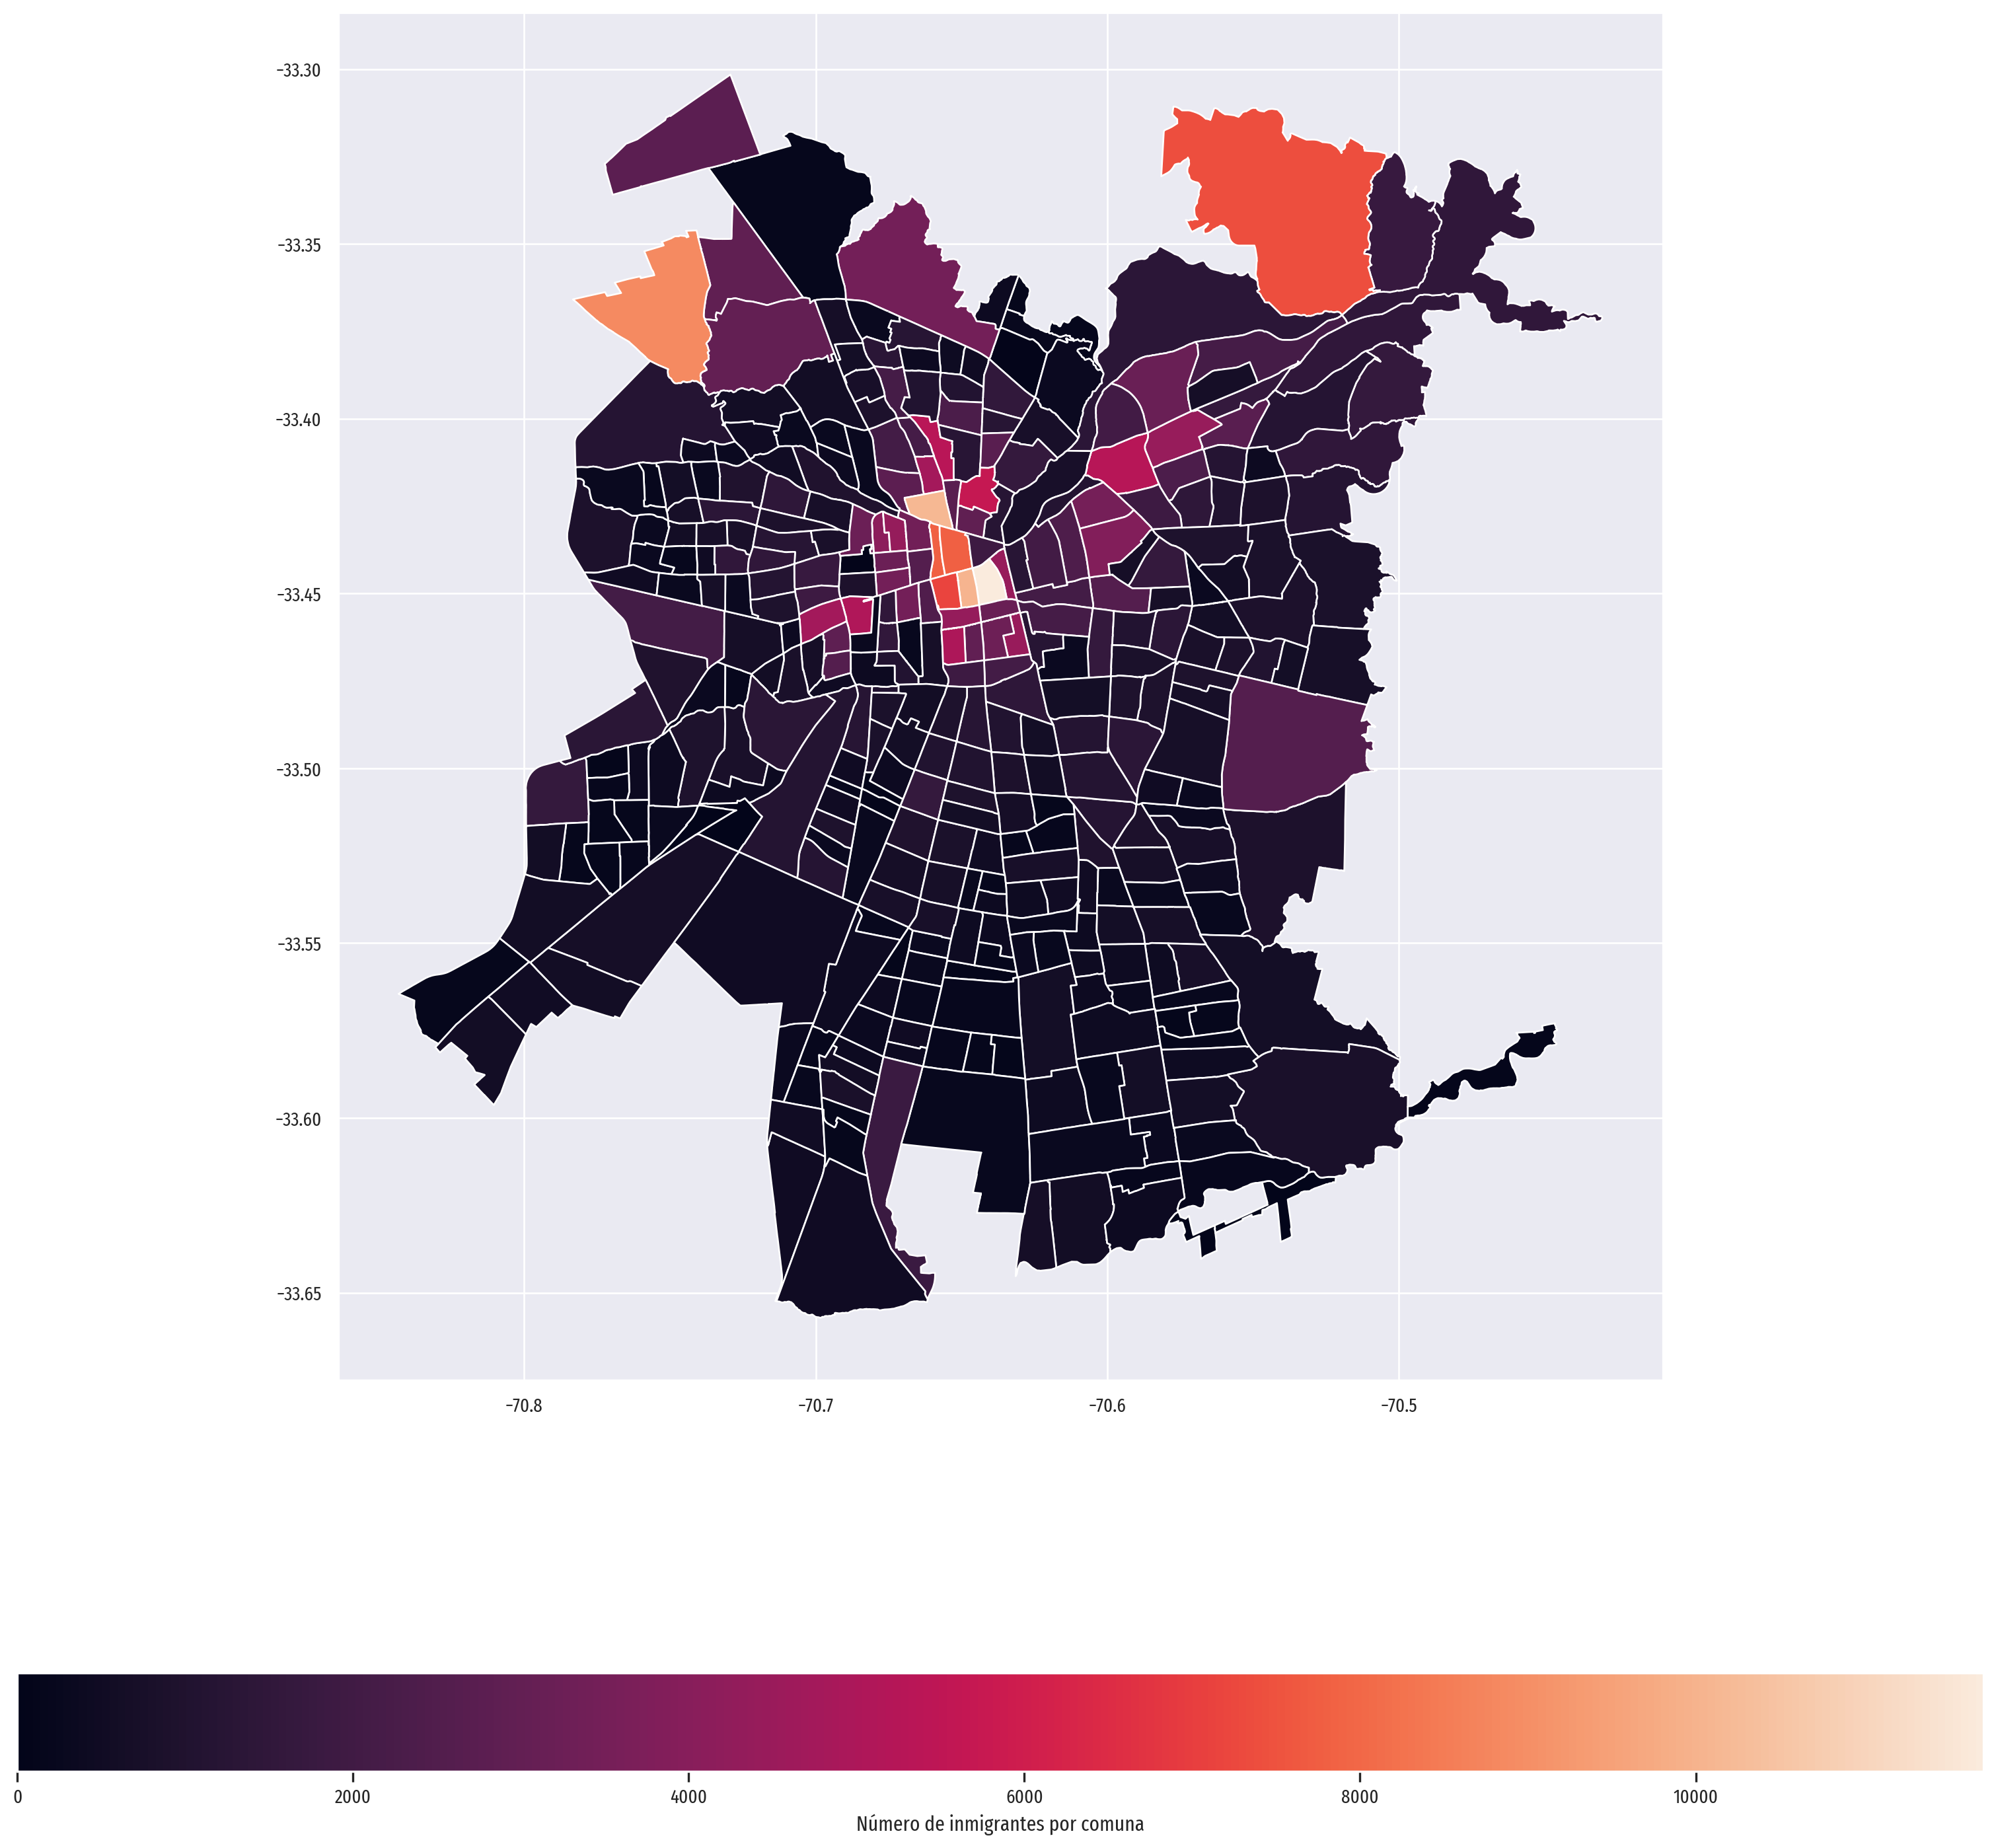

In [30]:
# Un gráfico de coropletas es útil para mostrar la variación de una variable medida en regiones geográficas.

# Se configura una figura y un eje con Matplotlib, especificando el tamaño de la figura.
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Se utiliza el método 'plot' del GeoDataFrame 'urban_data' para crear el mapa de cloropletas.
# 'column='INMIGRANTES'' indica que los valores de la columna 'INMIGRANTES' determinarán el color de cada área en el mapa.

urban_data.plot(column='INMIGRANTES', ax=ax, legend=True,
         legend_kwds={'label': "Número de inmigrantes por comuna",  # Configura la etiqueta de la leyenda
                      'orientation': "horizontal"})  # Establece la orientación de la leyenda como horizontal

# Muestra el gráfico.
plt.show()

Calculemos las variables que necesitamos para responder nuestras preguntas iniciales.

In [31]:
urban_data['POPULATION'] = urban_data['HOMBRES'] + urban_data['MUJERES']
urban_data.POPULATION.describe()

count      347.000000
mean     17814.080692
std      12749.284236
min        440.000000
25%      11300.500000
50%      14693.000000
75%      20430.500000
max      98090.000000
Name: POPULATION, dtype: float64

In [32]:
# Calcular el ratio de diferencia porcentual entre mujeres y hombres respecto a la población total.
urban_data['RATIO'] = ((urban_data['MUJERES'] - urban_data['HOMBRES']) / urban_data['POPULATION'] * 100)

# Obtener estadísticas descriptivas de la columna 'RATIO' para entender su distribución, centralidad y dispersión.
urban_data.RATIO.describe()


count    347.000000
mean       2.740746
std        5.566922
min      -83.073011
25%        1.295353
50%        2.726106
75%        4.467027
max       11.570881
Name: RATIO, dtype: float64

**Interpretación de la variable RATIO:**

- Un RATIO positivo indica un mayor porcentaje de mujeres en comparación con hombres en la población.
- Un RATIO negativo sugiere un mayor porcentaje de hombres en comparación con mujeres.
- Un RATIO cercano a cero implica una distribución casi equitativa entre mujeres y hombres en esa área.

In [33]:
urban_data['INMIGRANT_%'] = urban_data['INMIGRANTES'] / urban_data['POPULATION'] * 100
urban_data['INMIGRANT_%'].describe()

count    347.000000
mean       8.126525
std        9.394703
min        0.000000
25%        2.384753
50%        4.796311
75%        8.771839
max       53.320236
Name: INMIGRANT_%, dtype: float64

In [34]:
urban_data['RETIRED_%'] = urban_data['EDAD_65YMAS'] / urban_data['POPULATION'] * 100
urban_data['RETIRED_%'].describe()

count    347.000000
mean      11.908847
std        4.004277
min        0.000000
25%        8.927512
50%       12.466019
75%       14.720273
max       20.260310
Name: RETIRED_%, dtype: float64

In [35]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
342      13        136   13604           1  REGIÓN METROPOLITANA DE SANTIAGO   
343      13        136   13604           3  REGIÓN METROPOLITANA DE SANTIAGO   
344      13        136   13604           4  REGIÓN METROPOLITANA DE SANTIAGO   
345      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
346      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI     DESC_COMUN                      DESC_DISTR  FID  \
0     SANTIAGO     LAS CONDES                      LAS CONDES    0   
1     SANTIAGO     LAS CONDES         SAN CARLOS DE APOQUINDO    0   
2     SANTIAGO     LAS CONDES                     CERRO CALÁN    0   
3     SANTIAGO     LAS CONDES               ESTADIO PALESTINO    0   
4     SANTIAGO     LAS CONDES                   HOSPITAL FACH    0   
..         ...            ...                             ...  ...   
342  TALAGANTE  PADRE HURTADO              CASA DE EJERCICIOS    0   
343  TALAGANTE  PADRE HURTADO                   PADRE HURTADO    0   
344  TALAGANTE  PADRE HURTADO                 VILLA LOS SILOS    0   
345  CHACABUCO          LAMPA                       LA VILANA    0   
346   SANTIAGO          MACUL  VILLA SANTA CAROLINA VILLA SAN    0   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.47940 -33.36434, -70.47931 -33.3...     7140     8978   
1    POLYGON ((-70.50045 -33.37855, -70.50037 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
342  POLYGON ((-70.80540 -33.55063, -70.80288 -33.5...     3556     3697   
343  POLYGON ((-70.79794 -33.55565, -70.79794 -33.5...     9742     9924   
344  POLYGON ((-70.82936 -33.57881, -70.82933 -33.5...    14139    14479   
345  POLYGON ((-70.72696 -33.32623, -70.72699 -33.3...    32895    32577   
346  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  POPULATION  \
0        1021       1562       10831         2466         1487       16118   
1         936       2489       12392          884         1632       17160   
2         616       1412        9940         2337         1180       14591   
3         949        999        9862         2195         1632       14323   
4        1033       1236       13872         2966         2716       19597   
..        ...        ...         ...          ...          ...         ...   
342       818        718        4888          309          158        7253   
343      1540       2193       13318         2205          508       19666   
344      2272       3598       19935         2003          593       28618   
345      7632       8898       44553         1758         2757       65472   
346       735        897        7854         1716          613       11562   

         RATIO  INMIGRANT_%  RETIRED_%  
0    11.403400     9.225710  15.299665  
1     5.361305     9.510490   5.151515  
2     8.094031     8.087177  16.016723  
3     8.175662    11.394261  15.325002  
4     7.373578    13.859264  15.134970  
..         ...          ...        ...  
342   1.944023     2.178409   4.260306  
343   0.925455     2.5831

## ¡Mapas!

Ahora que calculamos las variables necesarias, grafiquemos los mapas :D

In [36]:
# Calcular los límites de los intervalos para 5 bins
bins = np.linspace(urban_data['INMIGRANT_%'].min(), urban_data['INMIGRANT_%'].max(), 6)  # 5 bins, 6 límites

# Inicializar una lista vacía para almacenar las etiquetas
labels = []

# Usar un bucle for para crear etiquetas para cada bin
for i in range(len(bins) - 1):
    start = int(bins[i])  # Inicio del intervalo
    end = int(bins[i+1])  # Fin del intervalo
    label = f"{start}-{end}"  # Crear la etiqueta como un rango
    labels.append(label)  # Añadir la etiqueta a la lista

# Discretizar la columna 'INMIGRANTES' usando los bins y las etiquetas
urban_data['INMIGRANTES_CAT'] = pd.cut(urban_data['INMIGRANT_%'], bins=bins, labels=labels, include_lowest=True)

In [37]:
bins

array([ 0.        , 10.66404715, 21.3280943 , 31.99214145, 42.65618861,
       53.32023576])

In [38]:
labels

['0-10', '10-21', '21-31', '31-42', '42-53']

**include_lowest=True** asegura que el límite más bajo se incluya en el primer bin, lo que es importante para incluir el valor mínimo de la columna en la categorización.

In [39]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
342      13        136   13604           1  REGIÓN METROPOLITANA DE SANTIAGO   
343      13        136   13604           3  REGIÓN METROPOLITANA DE SANTIAGO   
344      13        136   13604           4  REGIÓN METROPOLITANA DE SANTIAGO   
345      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
346      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI     DESC_COMUN                      DESC_DISTR  FID  \
0     SANTIAGO     LAS CONDES                      LAS CONDES    0   
1     SANTIAGO     LAS CONDES         SAN CARLOS DE APOQUINDO    0   
2     SANTIAGO     LAS CONDES                     CERRO CALÁN    0   
3     SANTIAGO     LAS CONDES               ESTADIO PALESTINO    0   
4     SANTIAGO     LAS CONDES                   HOSPITAL FACH    0   
..         ...            ...                             ...  ...   
342  TALAGANTE  PADRE HURTADO              CASA DE EJERCICIOS    0   
343  TALAGANTE  PADRE HURTADO                   PADRE HURTADO    0   
344  TALAGANTE  PADRE HURTADO                 VILLA LOS SILOS    0   
345  CHACABUCO          LAMPA                       LA VILANA    0   
346   SANTIAGO          MACUL  VILLA SANTA CAROLINA VILLA SAN    0   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.47940 -33.36434, -70.47931 -33.3...     7140     8978   
1    POLYGON ((-70.50045 -33.37855, -70.50037 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
342  POLYGON ((-70.80540 -33.55063, -70.80288 -33.5...     3556     3697   
343  POLYGON ((-70.79794 -33.55565, -70.79794 -33.5...     9742     9924   
344  POLYGON ((-70.82936 -33.57881, -70.82933 -33.5...    14139    14479   
345  POLYGON ((-70.72696 -33.32623, -70.72699 -33.3...    32895    32577   
346  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  POPULATION  \
0        1021       1562       10831         2466         1487       16118   
1         936       2489       12392          884         1632       17160   
2         616       1412        9940         2337         1180       14591   
3         949        999        9862         2195         1632       14323   
4        1033       1236       13872         2966         2716       19597   
..        ...        ...         ...          ...          ...         ...   
342       818        718        4888          309          158        7253   
343      1540       2193       13318         2205          508       19666   
344      2272       3598       19935         2003          593       28618   
345      7632       8898       44553         1758         2757       65472   
346       735        897        7854         1716          613       11562   

         RATIO  INMIGRANT_%  RETIRED_% INMIGRANTES_CAT  
0    11.403400     9.225710  15.299665            0-10  
1     5.361305     9.510490   5.151515            0-10  
2     8.094031     8.087177  16.016723            0-10  
3     8.175662    11.394261  15.325002           10-21  
4     7.373578    13.859264  15.134970           10-21  
..         

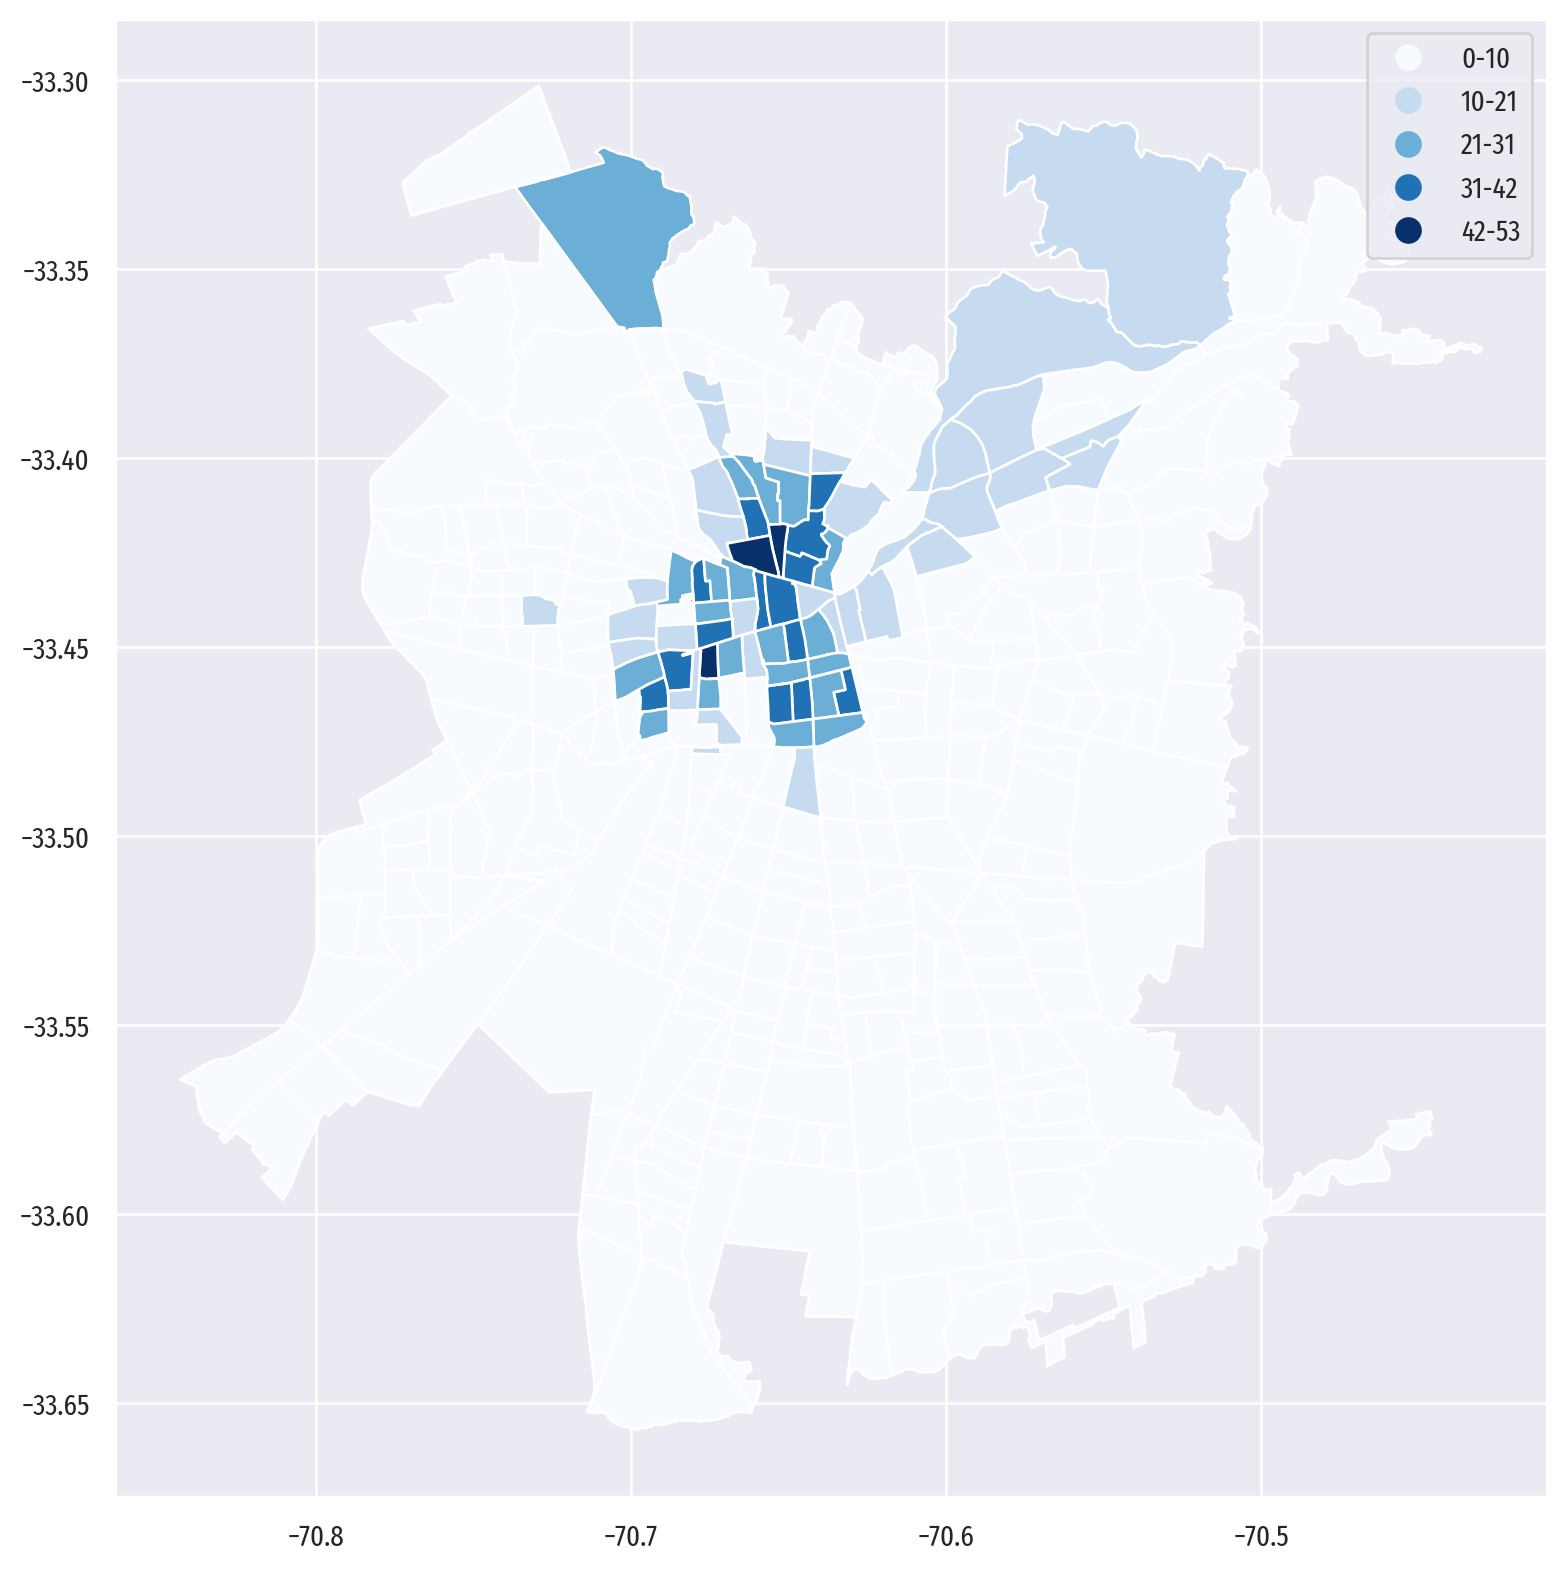

In [40]:
# Crear una paleta de colores con 5 colores
cmap = plt.get_cmap('Blues', 5)  # 'viridis' es un ejemplo de mapa de colores

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
divider = urban_data.plot(column='INMIGRANTES_CAT', ax=ax, legend=True, cmap=cmap)

plt.show()

Ahora vamos a dibujar los bordes del mapa

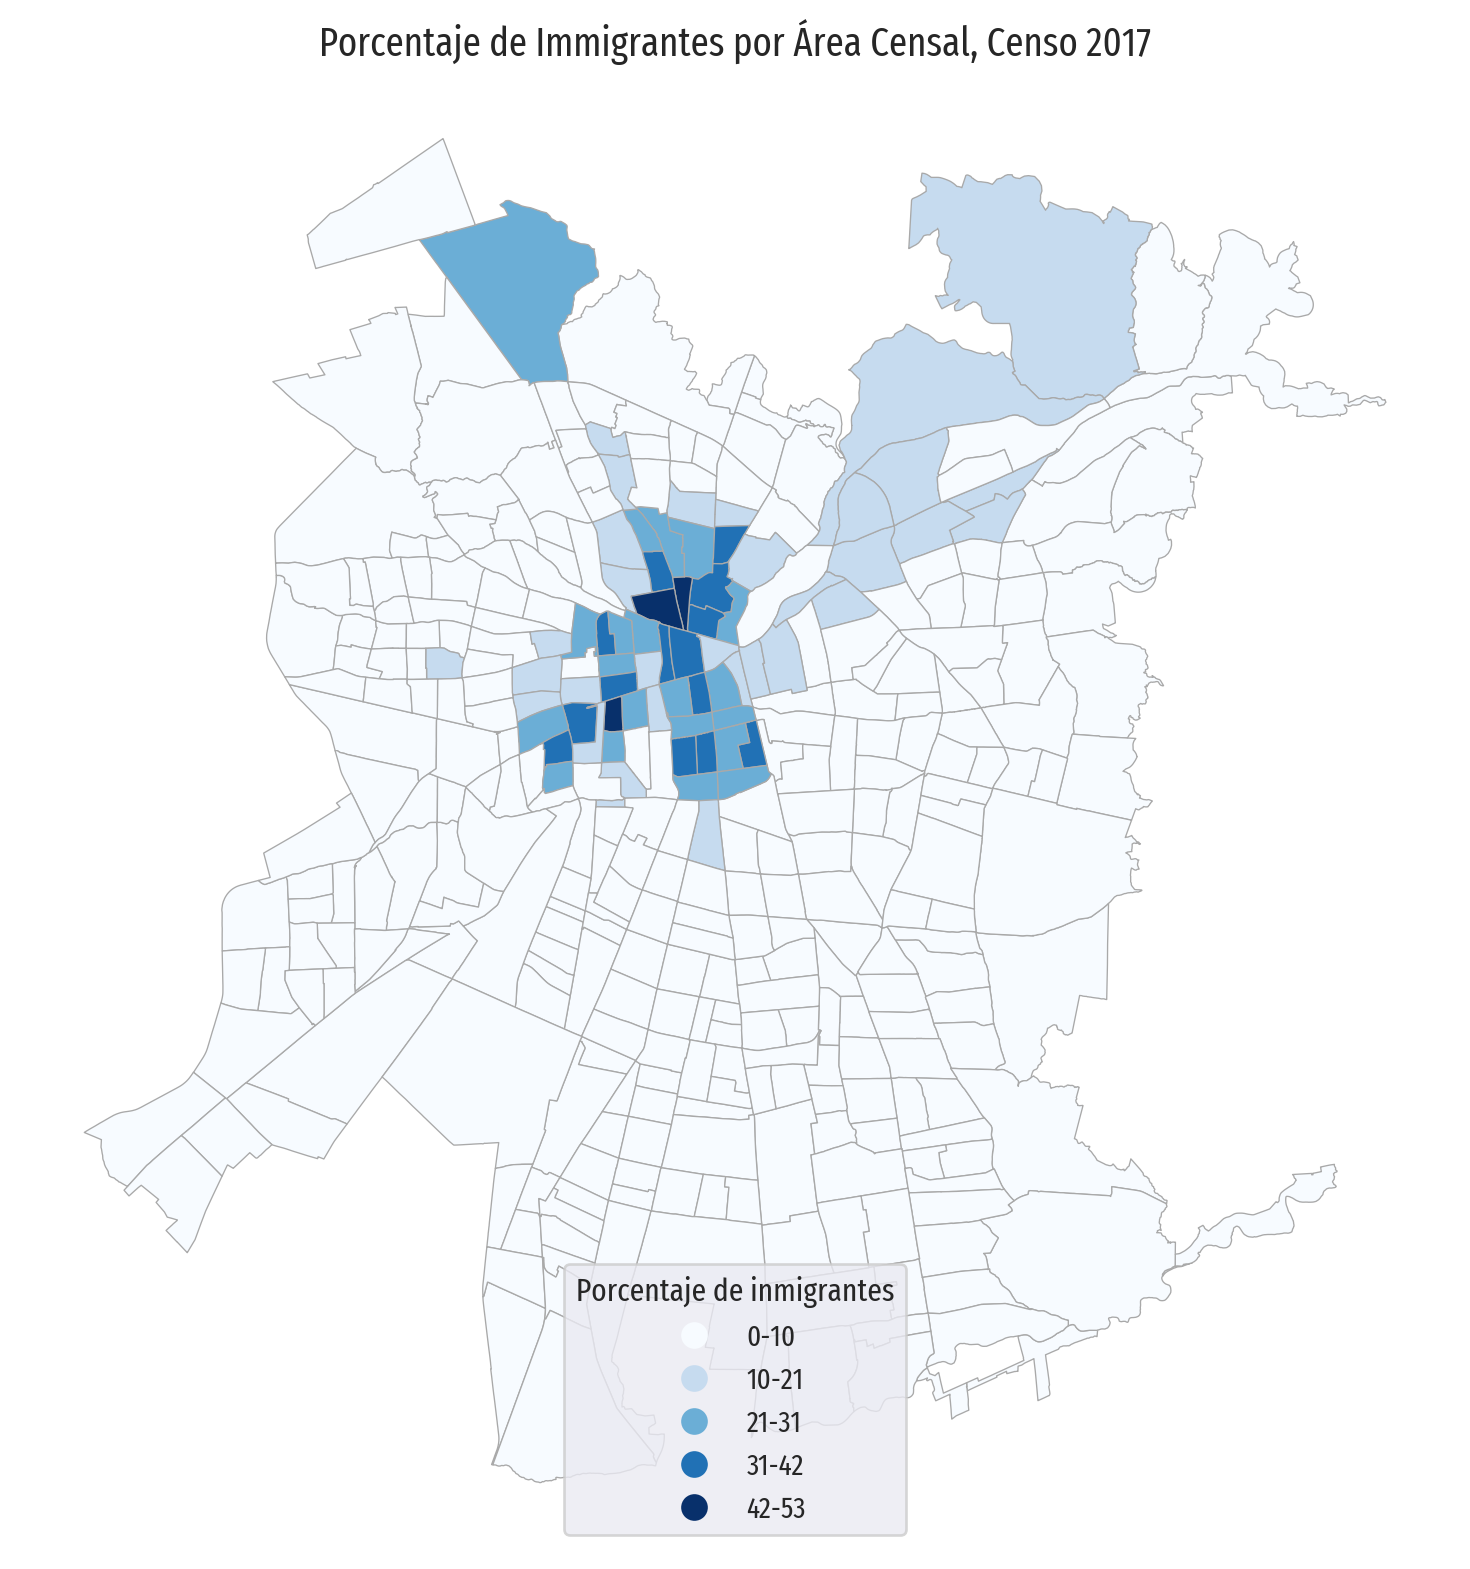

In [41]:
# Crear una paleta de colores con 5 tonos de azul
cmap = plt.get_cmap('Blues', 5)  # 'Blues' para usar tonos de azul

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_data.plot(column='INMIGRANTES_CAT', ax=ax, legend=True, cmap=cmap, edgecolor='darkgrey', linewidth=0.5,# Añade bordes grises oscuros
                legend_kwds={'title': "Porcentaje de inmigrantes", 'loc': 'lower center'})
# Agregar título y ajustes adicionales
ax.set_title("Porcentaje de Immigrantes por Área Censal, Censo 2017", fontsize=15)
ax.set_axis_off()  # Opcional: elimina los ejes para una visualización más limpia

plt.show()


La leyenda nos molesta así que vamos a ponerla en una posicion tal que no choque con el mapa

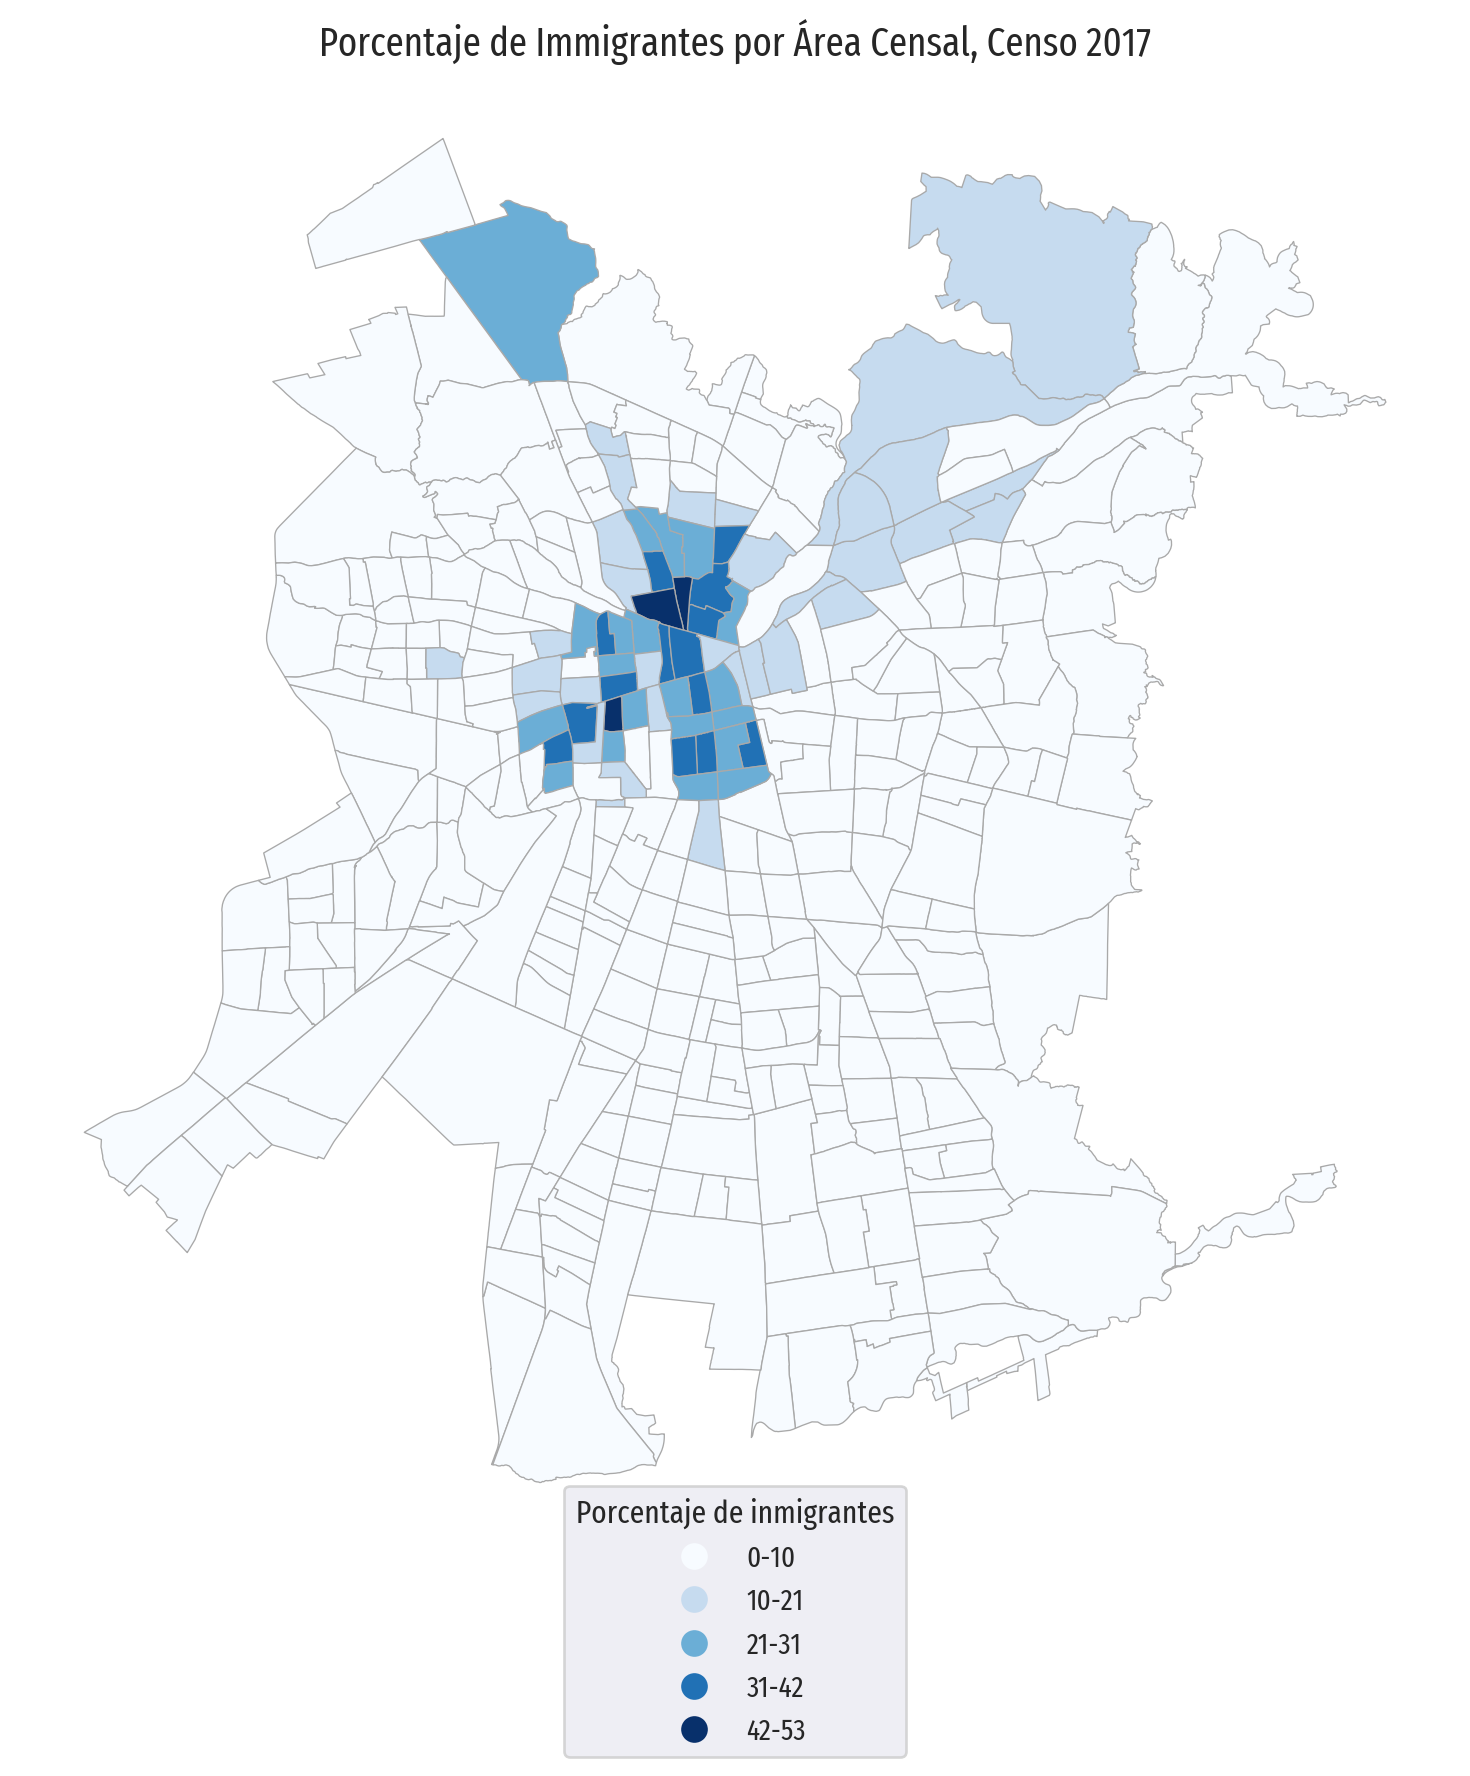

In [42]:
# Crear una paleta de colores con 5 tonos de azul
cmap = plt.get_cmap('Blues', 5)  # 'Blues' para usar tonos de azul

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_data.plot(column='INMIGRANTES_CAT', ax=ax, legend=True,
                cmap=cmap, edgecolor='darkgrey', linewidth=0.5,
                legend_kwds={'title': "Porcentaje de inmigrantes", 'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.15)})

# Agregar título y ajustes adicionales
ax.set_title("Porcentaje de Immigrantes por Área Censal, Censo 2017", fontsize=15)
ax.set_axis_off()  # Opcional: elimina los ejes para una visualización más limpia

plt.show()


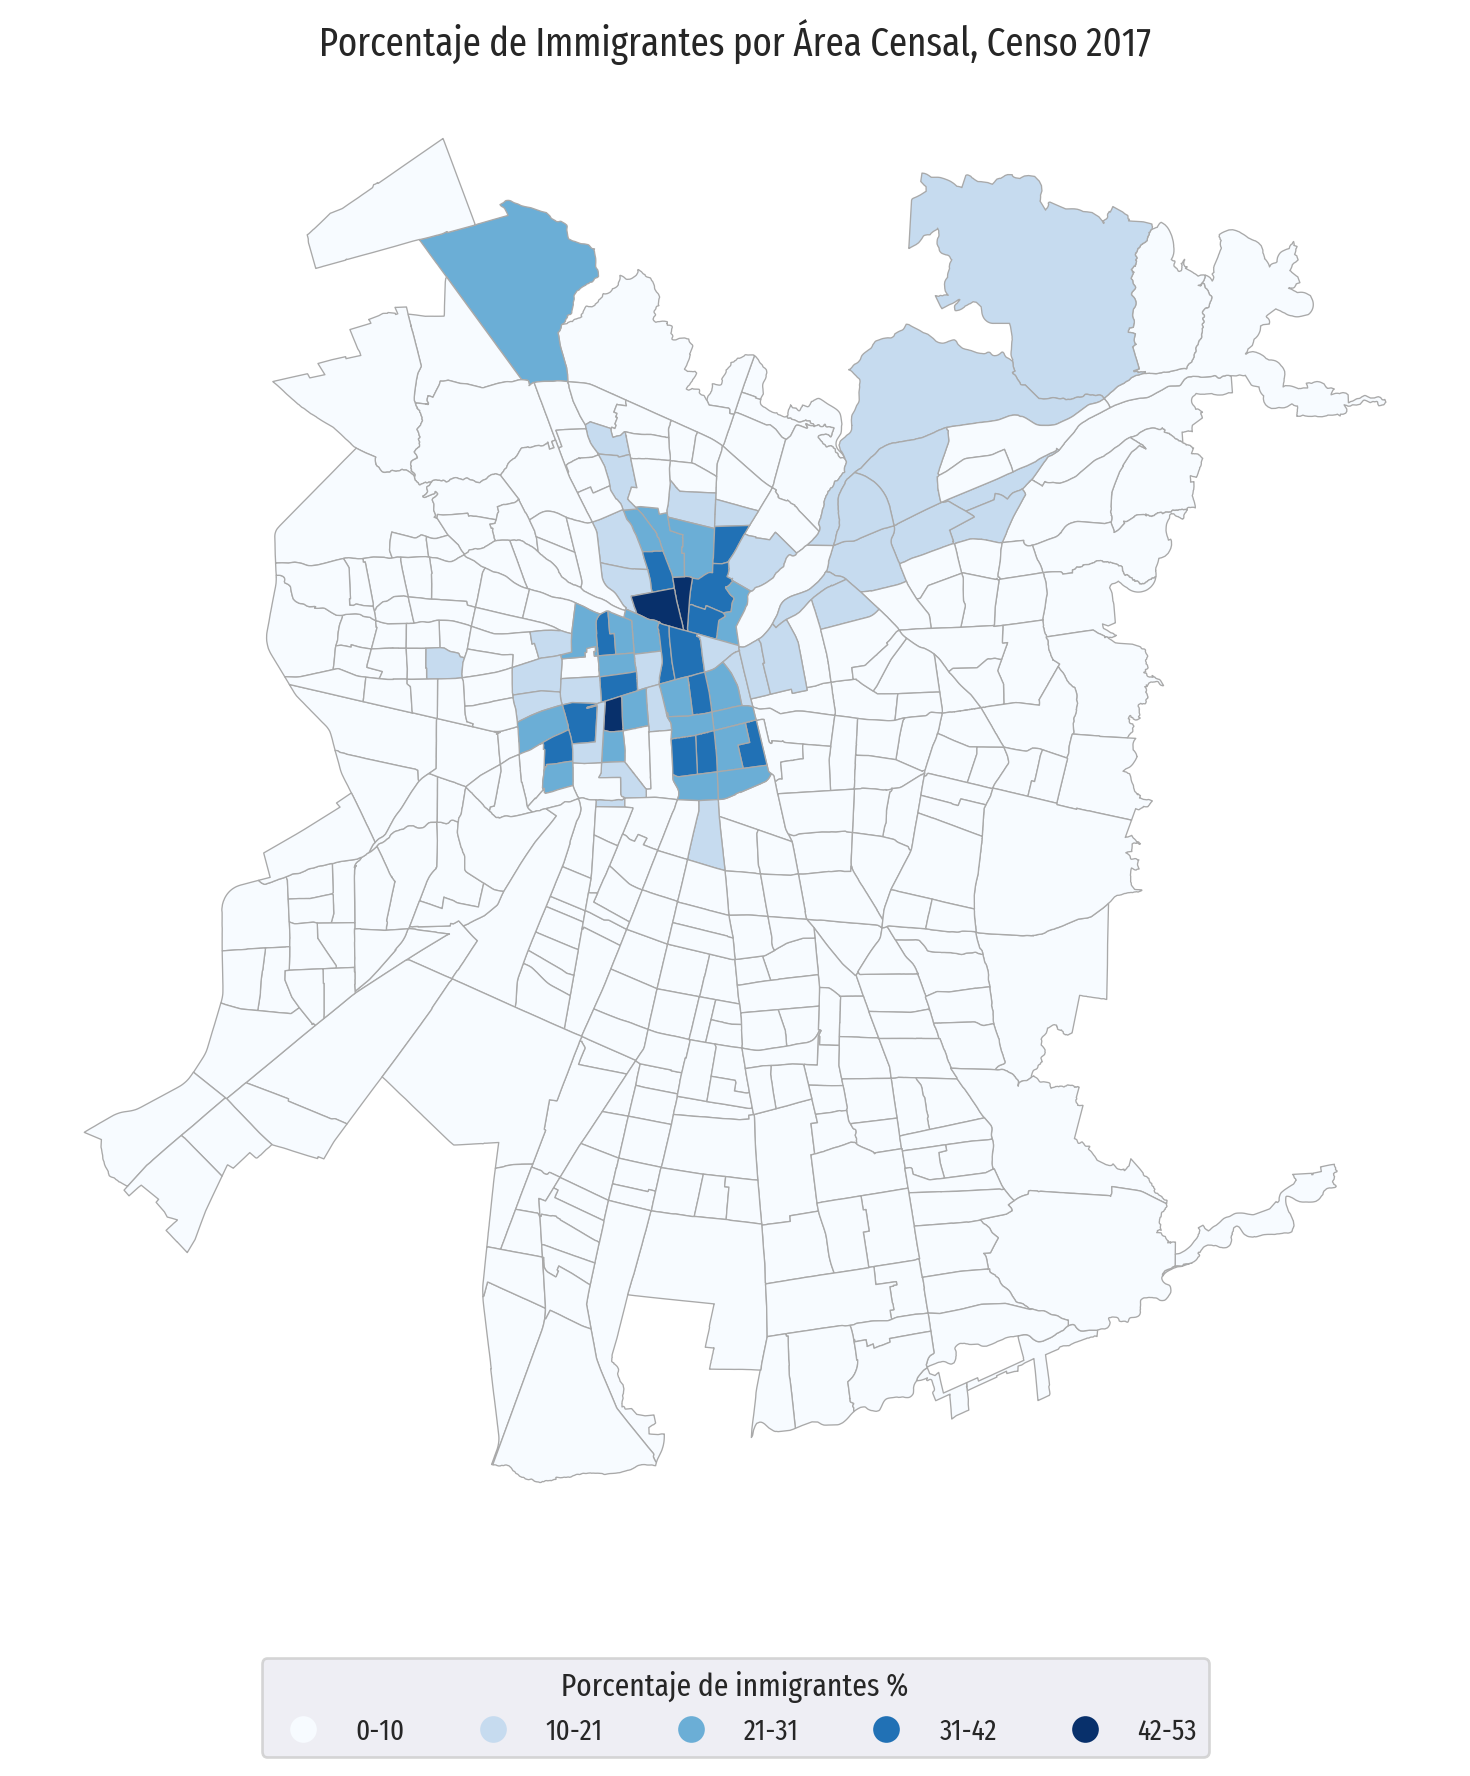

In [43]:
# Crear una paleta de colores con 5 tonos de azul
cmap = plt.get_cmap('Blues', 5)  # 'Blues' para usar tonos de azul

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_data.plot(column='INMIGRANTES_CAT', ax=ax, legend=True,
                cmap=cmap, edgecolor='darkgrey', linewidth=0.5,
                legend_kwds={'title': "Porcentaje de inmigrantes %", 'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.15), 'ncol':5})

# Agregar título y ajustes adicionales
ax.set_title("Porcentaje de Immigrantes por Área Censal, Censo 2017", fontsize=15)
ax.set_axis_off()  # Opcional: elimina los ejes para una visualización más limpia

plt.show()


In [44]:
!mkdir -p censo2017_figuras

In [45]:
fig.savefig('censo2017_figuras/migrants.png', dpi=150, bbox_inches='tight')

# Actividad 1

Cree un mapa coroplético de la columna **'Retirados'**, asegurándose de incluir una leyenda explicativa.Utilice una paleta distinta a 'Blues'. Analice y discuta las áreas con alta y baja concentración de personas retiradas, y presente sus hallazgos en forma de una breve.

Puntaje: 0.5 pts base de nota en el próximo control

# Actividad 2

Cree una visualización de coropletas en donde visualice la columna RATIO (la relacion entre el numero de mujeres y hombres) y que muestre en donde el porcentaje de mujeres es mayor o menor que los hombres. Us
e una paleta divergente. Ponga atención a la creación de los bins.

Puntaje: 0.5 pts base de nota en el próximo control

## Fin

Con eso terminamos este ejercicio. Hay hartos caminos por seguir:

  * ¿Cómo interpretarías estos datos?¿Qué hipótesis tienes respecto a los resultados?
  * ¿Con cuáles datasets los cruzarías?
  * ¿Qué otras ciudades te gustaría ver? En teoría solamente debemos cambiar el área urbana que estudiamos, el código debiese ser el mismo (excepto para el mapa de mujeres/hombres, en el que hay que ajustar las _bins_ de la escala de colores).
  